# Notebook for Image Segmentation using U-Net

This notebook uses the U-Net model from [this paper](https://arxiv.org/abs/1505.04597) to do pixel-level segmentation of rat tibia bone. The architeture of the model is showed in the image below
![title](img/U-Net.png)
Fig. 1. U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue
box corresponds to a multi-channel feature map. The number of channels is denoted
on top of the box. The x-y-size is provided at the lower left edge of the box. White
boxes represent copied feature maps. The arrows denote the different operations.

The entire project was made using [Tensorflow](https://www.tensorflow.org), an open-source software library written in Python, C++ and Cuda, for dataflow programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks. It is used for both research and production at Google, often replacing its closed-source predecessor, DistBelief.

TensorFlow was developed by the Google Brain team for internal Google use. It was released under the Apache 2.0 open source license on November 9, 2015.

With the the help of the python library [Keras](https://keras.io), an open source neural network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, Theano, or MXNet.

The basic idea is to generate a mask using the network to receive an image like this:
![title](images/osso1.png) and generate a output like this ![title](images/osso1mask.png)

In [30]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
import brine
import cv2
from PIL import Image
import os

import numpy as np
from model.augmentations import randomHueSaturationValue, randomShiftScaleRotate, randomHorizontalFlip
import model.u_net as unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Install and load the dataset
We'll use [brine](https:\\brine.io) to get and load the dataset.

The dataset consists of images of rat tibia bone in context and a mask for each image.


In [31]:
bones = brine.load_dataset('mike/bone-with-mask-2')

In [32]:
print('Dataset size:', len(bones))
print('Columns:', bones.columns)
print(bones[0].image)

Dataset size: 4
Columns: Column(image=Column(name=image, type=Image), mask=Column(name=mask, type=Image))
osso0.png


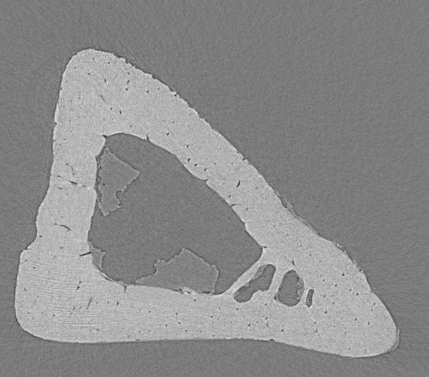

In [33]:
bones.load_image(bones[1].image)

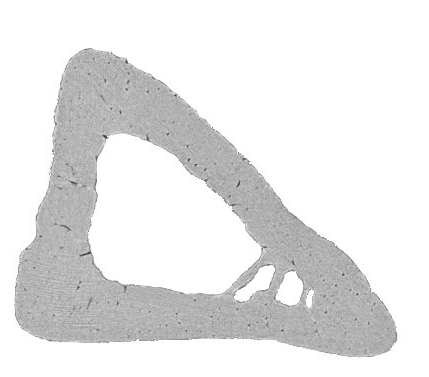

In [37]:
bones.load_image(bones[1].mask)

# The model

In [38]:
model = unet.get_unet_256(num_classes=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 256, 256, 32) 128         conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 256, 256, 32) 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_35 

Note the input is a 256x256x1 numpy array (the source image), and the output will be a 256x256x1 numpy array (the mask). brine's `to_keras` method will let us apply a processing function to each row of the image. Let's write our processing functions for the training data and the validation data to get the images into the appropriate shape. We'll also use data augmentation for the training data

In [ ]:
# Must be reshaped to the same dimensions of the Network Input. 
# Unfortonately my GPU (Nvidia GTX 460m) works with at maximum of U-Net 256 Architecture
SIZE = (256, 256)

In [40]:
# Method to set grayscale mask values to either 0 or 255
# And change the background to black and the bone parts to white
def fix_mask(mask):
    mask[mask < 240] = 255.0
    mask[mask >= 240] = 0.0
    

In [41]:
# Processing function for the training data
def train_process(data):
    img, mask = data
    img = img[:,:]
    mask = mask[:, :]
    ret,mask = cv2.threshold(mask,240,255,cv2.THRESH_BINARY_INV)  
    mask = mask.astype(float)
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(0, 0),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.0625, 0.0625),
                                       scale_limit=(-0.1, 0.1),
                                       rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)

    ret,mask = cv2.threshold(mask,240,255,cv2.THRESH_BINARY)  
    mask = mask.astype(float)
    img = img/255.
    mask = mask/255.
    img = np.expand_dims(img, axis=2)
    mask = np.expand_dims(mask, axis=0)
    return (img, mask)

In [42]:
# Processing function for the validation data, no data augmentation
def validation_process(data):
    img, mask = data
    img = img[:,:]
    mask = mask[:, :]
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(mask,240,255,cv2.THRESH_BINARY_INV)    
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = img/255.
    mask = mask.astype(float)
    mask = mask/255.
    img = np.expand_dims(img, axis=2)
    mask = np.expand_dims(mask, axis=0)
    return (img, mask)

# Create the folds and generators

Using brine's `create_folds` method, we'll split our dataset into validation and training folds, with 1 samples in the validation set and the rest (3) in the training set. We'll then use brine's `to_keras` method to create keras-compatible generators for each of the folds with the appropriate processing function applied

In [151]:
BATCH_SIZE = 1

In [153]:
validation_fold, train_fold = bones.create_folds((1,))
print('Validation fold size:', len(validation_fold))
print('Train fold size:', len(train_fold))

Validation fold size: 1
Train fold size: 3


In [154]:
train_generator = train_fold.to_keras('image',  # Which column we want to use for our 'xs'
                                      'mask',   # Which column we want to use for our 'ys'
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      processing_function=train_process)

In [156]:
validation_generator = validation_fold.to_keras('image',
                                                'mask',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                processing_function=validation_process)

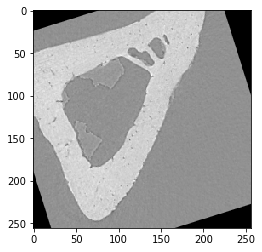

In [157]:
image, mask = next(train_generator)
imgplt = image[0].reshape(SIZE)
plt.imshow(imgplt, cmap='gray')

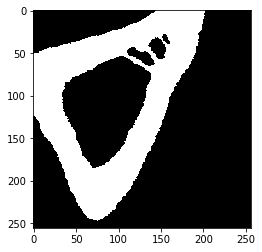

In [158]:
plt.imshow(mask[0].reshape(SIZE), cmap='gray')

# Training the model

We'll use the some callbacks from Kaggle Experts. Early stopping to stop when our validation loss stops improving, reducing the learning rate based on validation loss and we save our best model. Then we'll train using keras' `fit_generator` for up to 100 epochs (though likely with this dataset we'll stop before then). 

In [159]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           min_delta=1e-5),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=5,
                               verbose=1,
                               epsilon=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='F:/Archnus/Documents/github/u-net-segmentation-example/weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [174]:
epochs=100
model.fit_generator(generator=train_generator,
                    steps_per_epoch=100,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch()
                   )

Epoch 1/100
100/100 [==============================] - 124s 1s/step - loss: 1.0261 - dice_coeff: 0.6403 - val_loss: 1.0568 - val_dice_coeff: 0.6410
Epoch 2/100
100/100 [==============================] - 124s 1s/step - loss: 1.0409 - dice_coeff: 0.6391 - val_loss: 1.0552 - val_dice_coeff: 0.6406
Epoch 3/100
100/100 [==============================] - 123s 1s/step - loss: 1.0297 - dice_coeff: 0.6425 - val_loss: 1.0557 - val_dice_coeff: 0.6422
Epoch 4/100
100/100 [==============================] - 124s 1s/step - loss: 1.0417 - dice_coeff: 0.6370 - val_loss: 1.0573 - val_dice_coeff: 0.6426
Epoch 5/100
100/100 [==============================] - 124s 1s/step - loss: 1.0217 - dice_coeff: 0.6403 - val_loss: 1.0570 - val_dice_coeff: 0.6417
Epoch 6/100
100/100 [==============================] - 124s 1s/step - loss: 1.0277 - dice_coeff: 0.6393 - val_loss: 1.0566 - val_dice_coeff: 0.6409
Epoch 7/100
100/100 [==============================] - 123s 1s/step - loss: 1.0223 - dice_coeff: 0.6392 - val_lo

In [188]:
def mask_image(image, mask):
    image[mask<=0] = 0
    return image

In [192]:
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    print(image.shape)
    print(predicted_mask.shape)
    image = image.reshape(SIZE)

    w=10
    h=10
    fig=plt.figure(figsize=(12, 8))
    columns = 4
    rows = 2
    fig.add_subplot(1, 3, 1)
#     ret,image = cv2.threshold(image,0.6,255,cv2.THRESH_BINARY) 
    plt.imshow(image, cmap='gray')
    plt.title("Image Normal")
    fig.add_subplot(1, 3, 2)
    ret,predicted_mask = cv2.threshold(predicted_mask,0.6,255,cv2.THRESH_BINARY) 
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Máscara Gerada")
    fig.add_subplot(1, 3, 3)
#     ret,predicted_mask = cv2.threshold(predicted_mask,0.5,255,cv2.THRESH_BINARY)    
#     plt.title("Aplicação da Máscara à imagem")
#     plt.imshow(image)
#     plt.imshow(predicted_mask, alpha=0.5, cmap='gray')
#     fig.add_subplot(1, 3, 3)
    image = mask_image(image, predicted_mask)
    plt.title("Máscara binária da imagem")
    plt.imshow(image, cmap='gray')
    plt.show()


(256, 256, 1)
(256, 256)


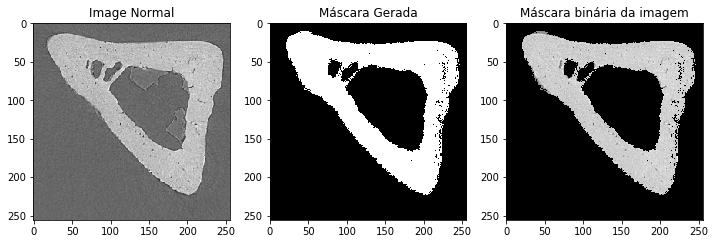

In [193]:
predict_one()

# Using the model to make predictions

We can now use the saved weights to make predictions in new images, and see the performance

In [20]:
model.load_weights('weights/best_weights.hdf5')

In [ ]:
predicted_mask = model.predict(newImage)